In [1]:
from tensorflow.keras.applications import VGG16
target_shape = (224,224,3)
inception = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=target_shape,
    pooling='avg')

2021-10-18 13:50:59.235606: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-18 13:50:59.235659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anton): /proc/driver/nvidia/version does not exist
2021-10-18 13:50:59.236513: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
inception.trainable = False

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model

input_layer = Input(target_shape, dtype = tf.uint8)
y = tf.cast(input_layer, tf.float32)
y = preprocess_input(y)

y = inception(y)
y = Flatten()(y)
model = Model(inputs=input_layer, outputs=y)

In [6]:
from Generator import VideoBatchGenerator
gen = VideoBatchGenerator(
    glob_pattern='videos/*.mp4',
    target_size=target_shape[:-1],
    channel=target_shape[-1],
    batch_size=128,
    fpm=30
    )

Found total 3 videos


In [7]:
len(gen)

62

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________

In [14]:
from tqdm import tqdm, tgrange

In [15]:
def predict(generator):
    for i in tgrange(len(generator), desc="Running Batch: "):
        prediction = model.predict(generator[i])
        yield (generator[i], prediction)

/home/rishi/Documents/EduGrad/Mentor Evaluator/env/lib/python3.7/site-packages/tqdm/gui.py:186: TqdmExperimentalWarning: GUI is experimental/alpha
  return tqdm_gui(_range(*args), **kwargs)


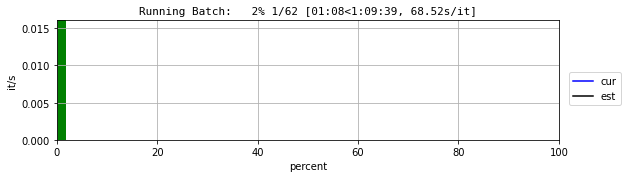

In [16]:
import joblib
for batch_i, (batch, prediction) in enumerate(predict(gen)):
    pickel_data = {'batch': batch,
                   'prediction':prediction}
    joblib.dump(pickel_data, 'predictions/{}.pkl'.format(batch_i))